## CNN for handwritten digit recognition

- Implemented a CNN model and training loop with Pytorch to predict the category of the handwritten digit image.
- Used the MNIST dataset, a image dataset including digit from 0 to 9, with a training set of 60,000 examples, and a test set of 10,000 examples.
- Downloaded the data files mnist_train.csv and mnist_test.csv from the following links:

    mnist_train.csv https://www.dropbox.com/s/gm82o0atvvpwc0f/mnist_train.csv?dl=0
    
    mnist_test.csv https://www.dropbox.com/s/jm1bz8rtp0ecfw1/mnist_test.csv?dl=0

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

from torchvision import transforms
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

In [2]:
# The arguments of the experiment
class Args:
    def __init__(self):
        # Based on the availablity of GPU, decide whether to run the experiment on cuda or cpu.
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # The random seed for the exp.
        self.seed = 1
        # The mini batch size of training and testing data. If you find you machines run very slow
        # or experience with OOM issue, you can set a smaller batch size
        self.batch_size = 50
        # The epochs of the exps. The referenced model achieve over 95% test accuracy after 1 epoch.
        self.epochs = 10
        # The learning rate of the SGD optimizer
        self.lr = 0.1
        # The momentum of SGD optimizer
        self.momentum = 0.5
        # how many iterations to display the training stats
        self.log_interval = 10
        # The height of input image
        self.img_h = 28
        # The width of the input image
        self.img_w = 28

args = Args()
torch.manual_seed(args.seed)

In [4]:
"""
Data Loader
"""
class MNIST_DATASET(Dataset):
    def __init__(self, csv_path, height, width, transform=None):
        """
        Custom dataset example for reading data from csv

        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transform = transform

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)

transformations = transforms.Compose([transforms.ToTensor()])

mnist_train = \
    MNIST_DATASET('./mnist_train.csv',
                             args.img_h, args.img_w,
                             transformations)
mnist_test = \
    MNIST_DATASET('./mnist_test.csv',
                             args.img_h, args.img_w,
                             transformations)
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                                    batch_size=args.batch_size,
                                                    shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                                    batch_size=args.batch_size,
                                                    shuffle=False)

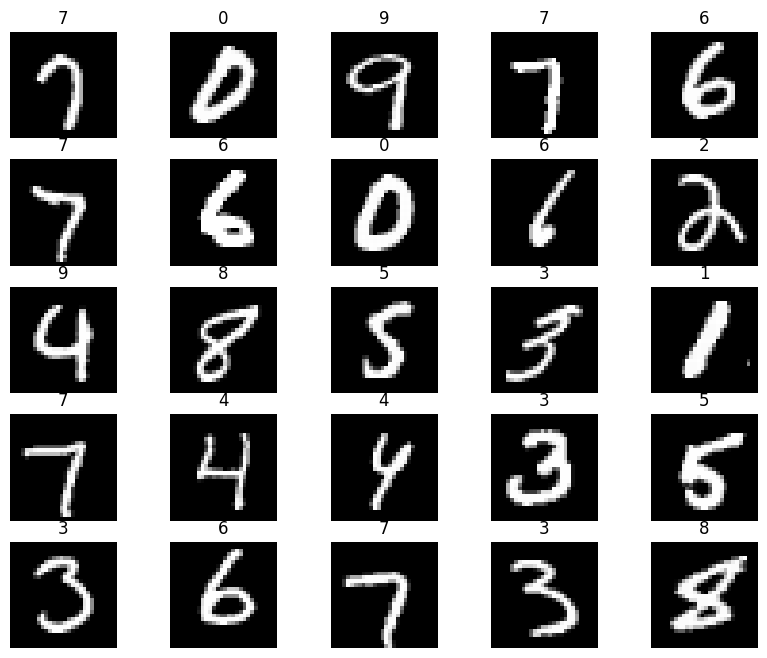

In [5]:
"""
Data Visualization
"""
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
"""
CNN Model
"""

class Model(nn.Module):
    """Custom CNN model to recognize the input handwritten digit image"""
    def __init__(self):
        """ Define and instantiate your layers"""
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 25, kernel_size=3),
                                    nn.BatchNorm2d(25),
                                    nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(25, 50, kernel_size=3),
                                    nn.BatchNorm2d(50),
                                    nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(nn.Linear(50 * 5 * 5, 1024),
                                nn.ReLU(inplace=True),
                                nn.Linear(1024, 128),
                                nn.ReLU(inplace=True),
                                nn.Linear(128, 10))

    def forward(self, x):
        """
        Run forward pass on input image X

        Args:
            x: torch tensor of input image,
                with shape of [batch_size * 1 * img_h * img_w]

        Return:
            out: torch tensor of predicted categorical distribution
                on input images, with shape of [batch_size, 10]

        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return nn.functional.log_softmax(x, dim=1), x

In [7]:
"""
Training Loop
"""
device = args.device
print('Using device {}'.format(device))
cnn = Model().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=args.lr, momentum=args.momentum)

def train(num_epochs, cnn):
    cnn.train()
    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(mnist_train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            prediction, _ = cnn(images)
            loss = loss_func(prediction, labels)
            loss.backward()
            optimizer.step()

            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(images), len(mnist_train_loader.dataset),
                    100. * batch_idx / len(mnist_train_loader), loss.item()))


train(args.epochs, cnn)

Using device cuda
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.329357
Train Epoch: 0 [500/60000 (1%)]	Loss: 1.662411
Train Epoch: 0 [1000/60000 (2%)]	Loss: 1.332804
Train Epoch: 0 [1500/60000 (2%)]	Loss: 0.531048
Train Epoch: 0 [2000/60000 (3%)]	Loss: 0.289934
Train Epoch: 0 [2500/60000 (4%)]	Loss: 0.405217
Train Epoch: 0 [3000/60000 (5%)]	Loss: 0.179882
Train Epoch: 0 [3500/60000 (6%)]	Loss: 0.206349
Train Epoch: 0 [4000/60000 (7%)]	Loss: 0.278852
Train Epoch: 0 [4500/60000 (8%)]	Loss: 0.099697
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.174090
Train Epoch: 0 [5500/60000 (9%)]	Loss: 0.148367
Train Epoch: 0 [6000/60000 (10%)]	Loss: 0.115224
Train Epoch: 0 [6500/60000 (11%)]	Loss: 0.109646
Train Epoch: 0 [7000/60000 (12%)]	Loss: 0.306707
Train Epoch: 0 [7500/60000 (12%)]	Loss: 0.104716
Train Epoch: 0 [8000/60000 (13%)]	Loss: 0.271598
Train Epoch: 0 [8500/60000 (14%)]	Loss: 0.131984
Train Epoch: 0 [9000/60000 (15%)]	Loss: 0.067755
Train Epoch: 0 [9500/60000 (16%)]	Loss: 0.286103
Train Epoch: 0 [10

In [8]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in mnist_test_loader:
            test_output, last_layer = cnn(images.to(device))
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels.to(device)).sum().item()
            total += labels.size(0)
    print('Test Accuracy of the model on the 10000 test images: %.2f %%' % (correct*100.0/total))
test()


Test Accuracy of the model on the 10000 test images: 99.42 %
